# Large Data

The bootstrapped library also provides functionality to deal with large-ish datasets. There are two situations where large data may pose issues. By large, we mean that it still fits reasnably in memory but is large enough that the bootstrap methods take considerable time to execute.
1. Memory
2. Time


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

In [2]:
import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats

In [3]:
test = np.random.normal(loc=100, scale=100, size=1000000) * 1.1
ctrl = np.random.normal(loc=100, scale=100, size=1000000) 

# Memory
Use 'iteration_batch_size' argument. This will help with the memory footprint at the cost of some speed.

In [4]:
# this will probably fail unless you have a LOT of memory
try:
    print(bs.bootstrap_ab(test, ctrl, bs_stats.sum, bs_compare.percent_change))
except MemoryError as e:
    print('There was a memory error - too much memory to be allocated')

There was a memory error - too much memory to be allocated


In [5]:
t = time.time()
results = bs.bootstrap_ab(test, ctrl, bs_stats.sum, bs_compare.percent_change, 
                          iteration_batch_size=1000)

print('Results {}'.format(results))
print('')
print('Seconds Taken {}'.format(time.time() - t))

Results 10.0181745751    (9.71428395746, 10.3221786039)

Seconds Taken 464.418161154


# Time
Use the 'num_threads' argument. This will spawn @num_threads processes to divide an conquer. This will usually speed up execution at the cost of CPU utilizaiton.

In [6]:
t = time.time()
results = bs.bootstrap_ab(test, ctrl, bs_stats.sum, bs_compare.percent_change, 
                          iteration_batch_size=500, num_threads=20)

print('Results {}'.format(results))
print('')
print('Seconds Taken {}'.format(time.time() - t))

Results 10.0181745751    (9.7088207046, 10.3279251239)

Seconds Taken 74.681885004


# A tip on Power
Power calculation simulations can take a very long time. Fortunately this method is easily parallelizable. 

In [7]:
def run_simulation(num_loops, lift, data):
    results = []
    for _ in range(num_loops):
        
        # in real life you would use real data and then apply some hypothetical lift to it
        sel = np.random.random(len(data)) > 0.5
        
        test = data[sel] * lift
        ctrl = data[~sel]
        
        r = bs.bootstrap_ab(test, ctrl, bs_stats.sum, bs_compare.percent_change, 
                            iteration_batch_size=500)
        results.append(r)
        
    return results

In [8]:
data = np.random.normal(loc=100, scale=100, size=20000) 

In [9]:
import multiprocessing
num_threads = 20
iterations_per_thread = int(np.ceil(3000/num_threads))

pool = multiprocessing.Pool(num_threads)

pow_results = []
for _ in range(num_threads):
    r = pool.apply_async(run_simulation, (iterations_per_thread, 1.05, data))
    pow_results.append(r)

pow_results = np.hstack([r.get() for r in pow_results])
pool.close()

In [10]:
import bootstrapped.power as bs_power

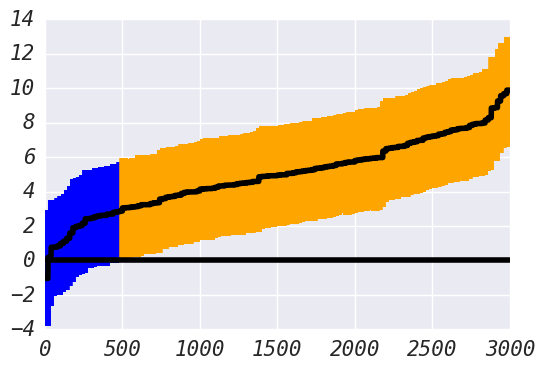

In [11]:
# take every 10th sample to make plotting a bit cleaner
bs_power.plot_power(pow_results)

In [12]:
# This test was positive but we should only expect to see a significantly positive 
# result ~15% of the time
bs_power.power_stats(pow_results)

,Percent
Insignificant,16.667
Negative,0.667
Negative Significant,0.000
Positive,99.333
Positive Significant,83.333
